In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import random
pio.templates.default = 'simple_white'
import datetime
import tqdm

### Time-series

In [2]:
! cp ../analyst_agent/full_data.csv .

In [3]:
ts_df = pd.read_csv('full_data.csv', sep = '\t')
ts_df['month_date'] = ts_df['date'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%m-01'))
ts_df = ts_df.pivot_table(index = 'month_date', columns = 'os', values = 'session_id', aggfunc = 'count').loc['2023-03-01':]


In [4]:
ts_df.map(int).head()

os          Android  Windows    iOS
month_date                         
2023-03-01   104500   131368   7781
2023-04-01   104504   132832  19960
2023-05-01   114563   146599  38045
2023-06-01   114581   148060  54079
2023-07-01   121795   159434  73914

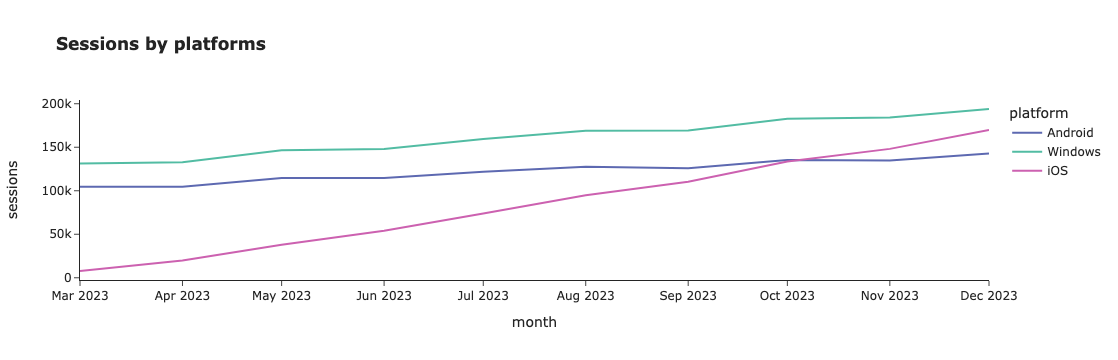

In [5]:
px.line(ts_df, title = '<b>Sessions by platforms</b>',
       labels = {'value': 'sessions', 'os': 'platform', 'month_date': 'month'},
       color_discrete_map={'Android': px.colors.qualitative.Vivid[1],
                            'Windows': px.colors.qualitative.Vivid[2],
                            'iOS': px.colors.qualitative.Vivid[4]})

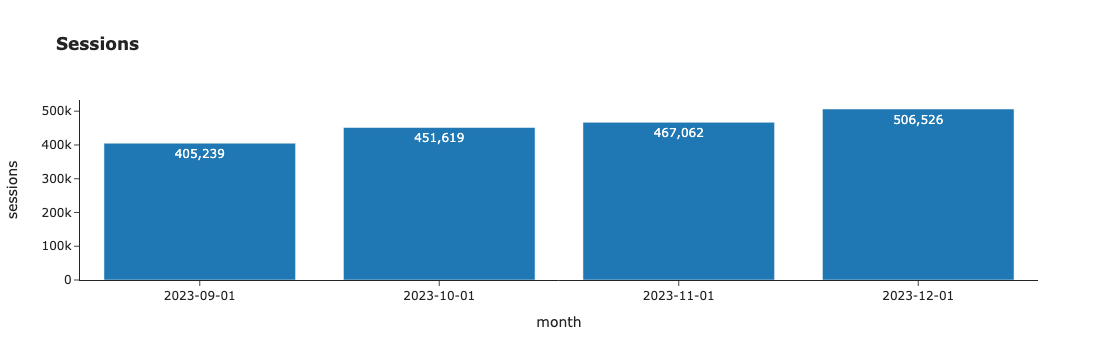

In [6]:
fig = px.bar(ts_df.loc['2023-09-01':].sum(axis = 1), title = '<b>Sessions</b>',
       labels = {'value': 'sessions', 'os': 'platform', 'month_date': 'month'}, text_auto = ',.6r')
fig.update_layout(xaxis_type='category')
fig.update_layout(showlegend = False)

In [7]:
ts_df = pd.read_csv('full_data.csv', sep = '\t')
ts_df = ts_df.pivot_table(index = 'date', columns = 'os', values = 'session_id', aggfunc = 'count').loc['2023-11-01':]
ts_df['Android'].loc['2023-12-18':] = ts_df.loc['2023-12-18':]['Android']*0.94
# ts_df['Android'] = (ts_df['Android']*14.2).map(lambda x: int(x))

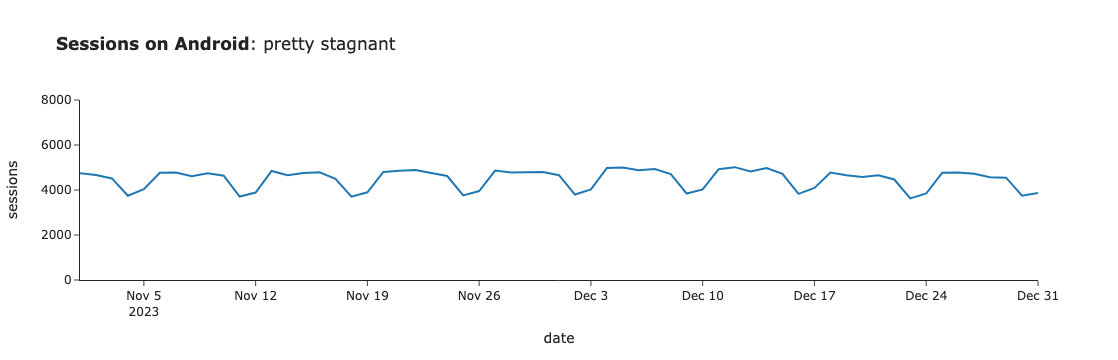

In [8]:
fig = px.line(ts_df[['Android']], title = '<b>Sessions on Android</b>: pretty stagnant', 
             labels = {'value': 'sessions', 'os': 'platform', 'month_date': 'month'})
fig.update_yaxes(range=[0, 8000])
fig.update_layout(showlegend = False)

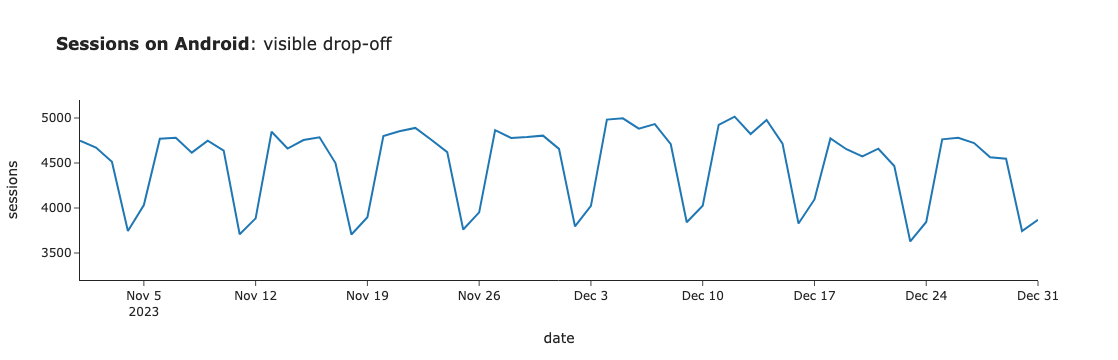

In [9]:
fig = px.line(ts_df[['Android']], title = '<b>Sessions on Android</b>: visible drop-off', 
             labels = {'value': 'sessions', 'os': 'platform', 'month_date': 'month'})
fig.update_yaxes(range=[3200, 5200])
fig.update_layout(showlegend = False)

### Correlation

In [11]:
mean = [24, 1000]
cov = [[50, 200], [200, 3000]]  
import matplotlib.pyplot as plt
import numpy as np
x, y = np.random.default_rng().multivariate_normal(mean, cov, 10000).T

In [12]:
corr_df = pd.DataFrame({'x': x, 'y': y})

In [13]:
corr_df = corr_df[corr_df.x >= 0]

In [14]:
# ! pip install scikit-learn

In [15]:
from sklearn import linear_model

In [16]:
regr = linear_model.LinearRegression()
regr.fit(corr_df[['x']], corr_df.y)

LinearRegression()

In [17]:
lin_corr_df = pd.DataFrame()
lin_corr_df['x'] = list(map(lambda x: round(x, -1), corr_df.x.unique()))
lin_corr_df.drop_duplicates()
lin_corr_df['linear_regression'] = regr.intercept_ + lin_corr_df.x * regr.coef_

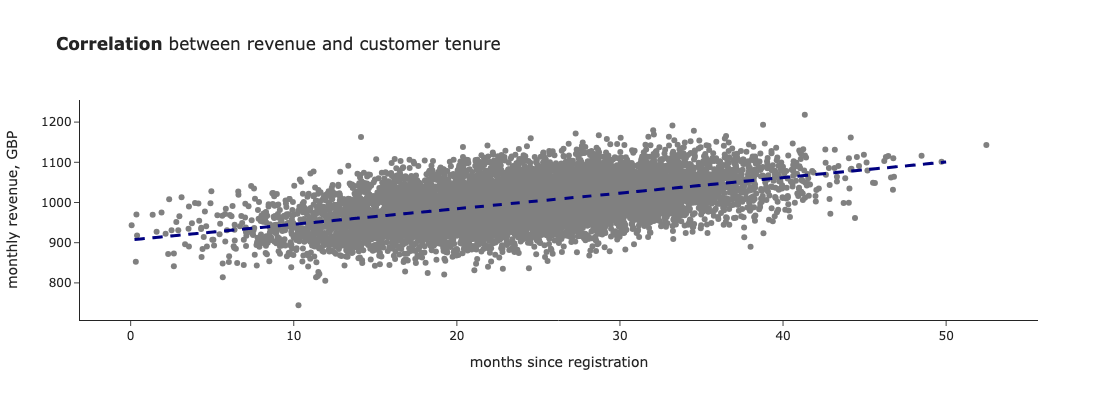

In [18]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=corr_df.x,
        y=corr_df.y,
        marker=dict(size=6, opacity=1, color = 'grey'),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        mode='lines',
        x=lin_corr_df.x,
        y=lin_corr_df.linear_regression,
        line=dict(color='navy', dash='dash', width = 3),
        showlegend=False
    )
)

fig.update_layout(width = 600, height = 400, title = '<b>Correlation</b> between revenue and customer tenure')
fig.update_xaxes(title = 'months since registration')
fig.update_yaxes(title = 'monthly revenue, GBP')

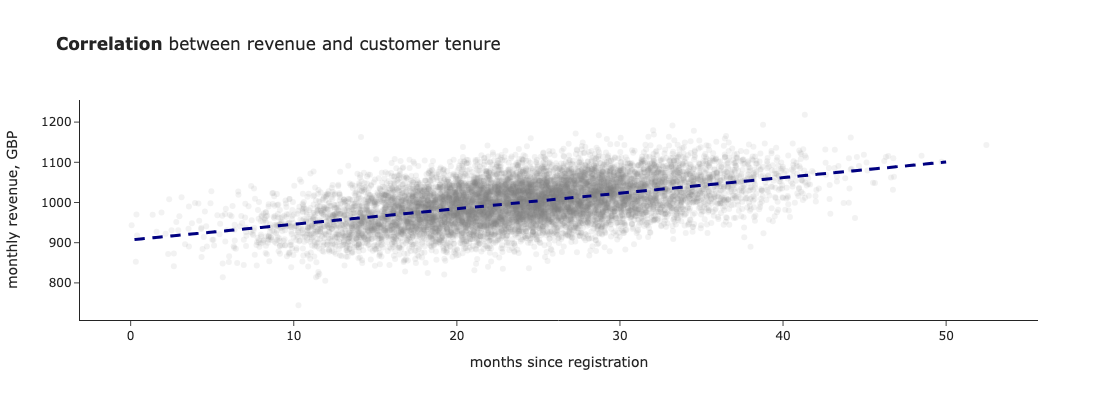

In [19]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=corr_df.x,
        y=corr_df.y,
        marker=dict(size=6, opacity=0.1, color = 'grey'),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        mode='lines',
        x=lin_corr_df.x,
        y=lin_corr_df.linear_regression,
        line=dict(color='navy', dash='dash', width = 3),
        showlegend=False
    )
)

fig.update_layout(width = 600, height = 400, title = '<b>Correlation</b> between revenue and customer tenure')
fig.update_xaxes(title = 'months since registration')
fig.update_yaxes(title = 'monthly revenue, GBP')

In [20]:
# ! pip install seaborn

In [21]:
import seaborn as sns

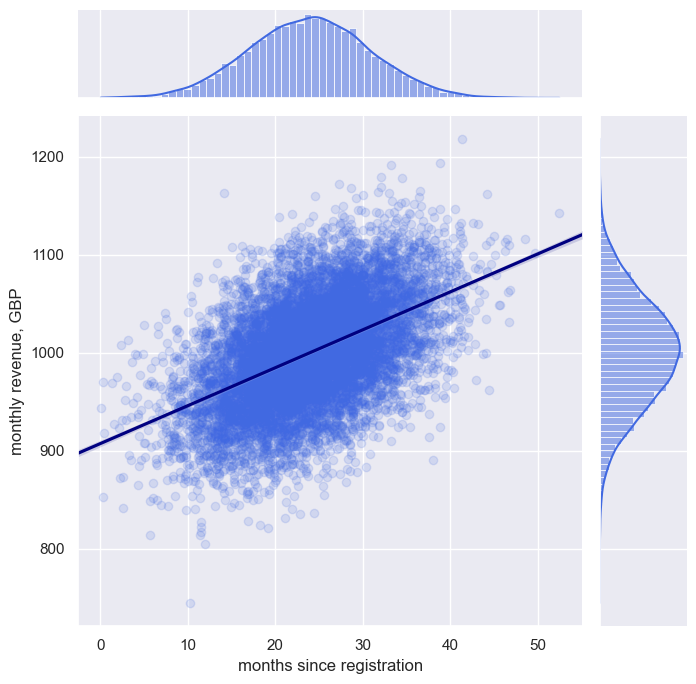

In [22]:
sns.set_theme(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.jointplot(x="x", y="y", data=corr_df,
                  kind="reg", truncate=False, joint_kws = {'scatter_kws':dict(alpha=0.15), 'line_kws':{'color':'navy'}},
                  # xlim=(0, 60), ylim=(0, 12),
                  color="royalblue", height=7)

g.set_axis_labels('months since registration', 'monthly revenue, GBP')

### Nominal comparison

In [23]:
age_groups = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
regions = ['United Kingdom', 'Germany', 'France', 'Switzerland']

In [24]:
gdp_per_capita = {
    'United Kingdom': 46510.28, 
    'Germany': 51203.55, 
    'France': 43658.98,
    'Switzerland': 91991.60
}

In [25]:
gmv_coef = 1000/gdp_per_capita['United Kingdom']

In [26]:
tmp_data = []

for i in range(len(age_groups)):
    for region in regions: 
        age_group = age_groups[i]
        value = gmv_coef * gdp_per_capita[region] * (1 + 0.1 * i + 0.1*random.random())

        tmp_data.append(
            {
                'age_group': age_group,
                'country': region,
                'gmv': value
            }
        )

In [27]:
gmv_df = pd.DataFrame(tmp_data)

In [28]:
gmv_df = gmv_df.pivot_table(index = 'country', columns = 'age_group', values = 'gmv').loc[
    ['United Kingdom', 'Germany', 'France', 'Switzerland']
]

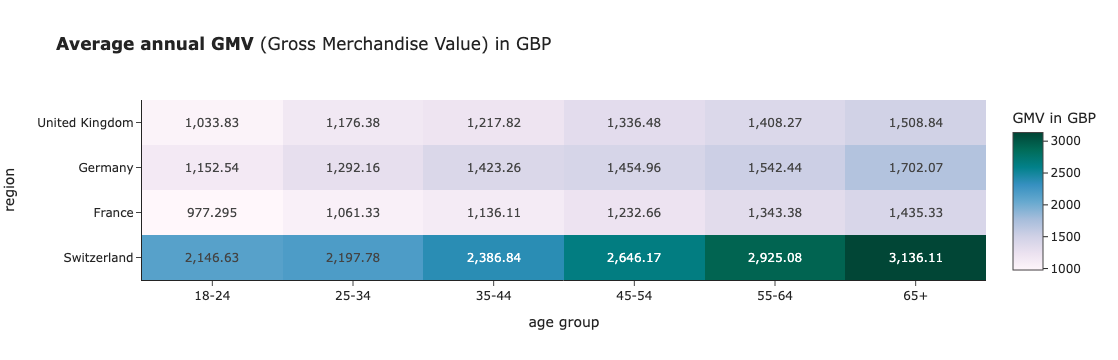

In [29]:
fig = px.imshow(gmv_df.values, 
                x = gmv_df.columns,
                y = gmv_df.index,
                text_auto=',.6r', aspect="auto",
               labels=dict(x="age group", y="region", color="GMV in GBP"), color_continuous_scale='pubugn',
               title = '<b>Average annual GMV</b> (Gross Merchandise Value) in GBP')
fig.show()

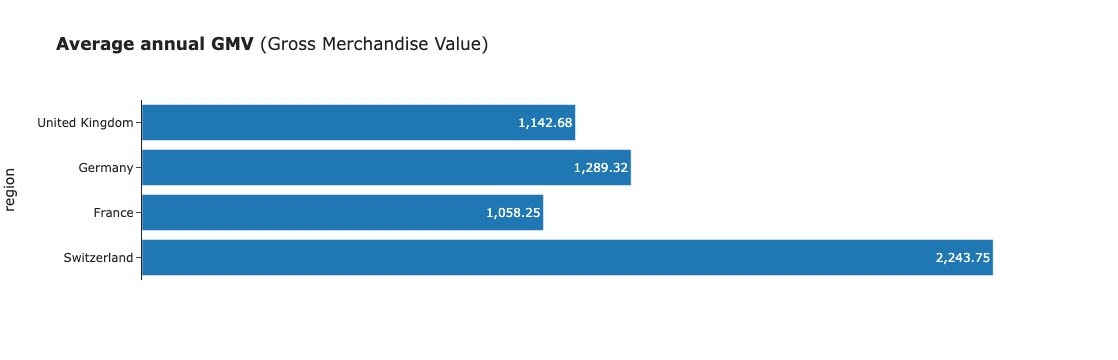

In [30]:
fig = px.bar(gmv_df[['18-24', '25-34', '35-44']].mean(axis = 1).loc[['Switzerland', 'France', 'Germany', 'United Kingdom']],
            text_auto = ',.6r', title = '<b>Average annual GMV</b> (Gross Merchandise Value)',
       labels = {'country': 'region', 'value': 'average GMV in GBP'}, orientation = 'h')
fig.update_layout(showlegend = False)
fig.update_xaxes(visible = False)

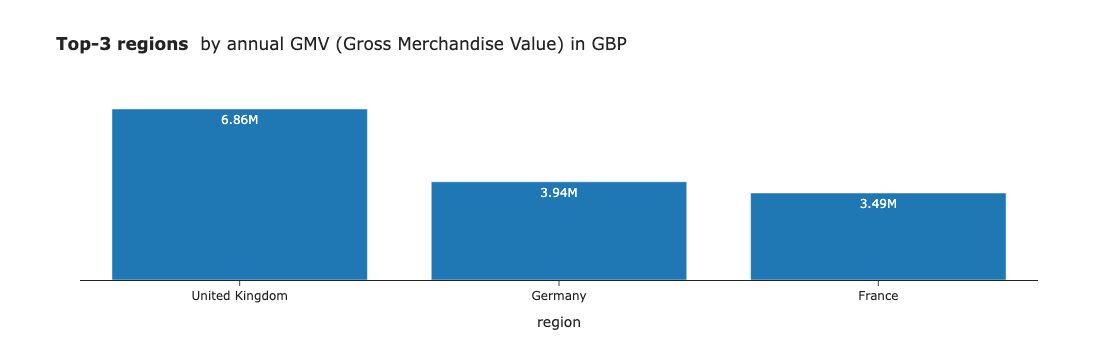

In [31]:
new_gmv_df = gmv_df[['18-24', '25-34', '35-44']].sum(axis = 1).apply(lambda x: round(1018.5 * x, -4)).loc[['Switzerland', 'Germany', 'United Kingdom']]
new_gmv_df.index = ['United Kingdom', 'Germany',  'France']

fig = px.bar(new_gmv_df,
            text_auto = True, title = '<b>Top-3 regions </b> by annual GMV (Gross Merchandise Value) in GBP',
       labels = {'index': 'region', 'value': 'average GMV in GBP'}, orientation = 'v')
fig.update_layout(showlegend = False)
fig.update_yaxes(visible = False)

### Part-to-whole

In [32]:
age_groups = ['25-34', '35-44', '18-24', '45-54', '55-64', '65+']
values = []

for i in range(len(age_groups)):
    base = 1000
    values.append(base / (i + 1))

In [33]:
base_df = pd.DataFrame({'age_group': age_groups, 'users': values})\
    .set_index('age_group')

In [34]:
whole_df = pd.DataFrame()
whole_df['United Kingdom'] = base_df.users.map(lambda x: x * (1 + 0.5*random.random()))
whole_df['Germany'] = base_df.users.map(lambda x: x * (1 + 0.5*random.random()))
whole_df['France'] = base_df.users.map(lambda x: x * (1 + 0.5*random.random()))
whole_df['Switzerland'] = base_df.users.map(lambda x: x * (1 + 0.5*random.random()))

In [35]:
whole_df.Switzerland.loc['65+'] = 4*whole_df.Switzerland.loc['65+']

In [36]:
whole_df = whole_df.T
whole_df

age_group             25-34       35-44       18-24       45-54       55-64  \
United Kingdom  1381.209557  643.793994  483.563705  285.648785  251.845419   
Germany         1440.468020  625.381478  421.771928  318.731700  211.844526   
France          1397.544427  628.836628  370.481335  267.301101  223.384788   
Switzerland     1436.197169  707.768978  442.871897  328.517361  288.137951   

age_group              65+  
United Kingdom  172.360076  
Germany         204.860853  
France          225.179534  
Switzerland     880.972420

In [ ]:
norm_whole_df = whole_df.apply(lambda x: 100*x/whole_df.sum(axis = 1))

In [ ]:
fig = px.bar(norm_whole_df.T[['United Kingdom']], title = '<b>Customer age,</b> United Kingdom',
       labels = {'value': 'share of users, %', 'age_group': 'customer age',}, text_auto = '.2f')
# fig.update_layout(xaxis_type='category')
fig.update_layout(showlegend = False)
fig.update_yaxes(visible = False)

In [ ]:
px.colors.sequential.Blues

In [ ]:
fig = px.bar(norm_whole_df.loc[['Switzerland', 'France', 'Germany', 'United Kingdom']], title = '<b>Customer age</b> in different regions',
       labels = {'value': 'share of users, %', 'age_group': 'customer age', 'index': 'region'}, orientation = 'h', text_auto = '.2f',
      color_discrete_sequence=px.colors.sequential.Teal)

fig.update_xaxes(visible = False)

In [ ]:
dyn_whole_df_base = pd.DataFrame(whole_df.T.Switzerland).T.reset_index().drop('index', axis = 1)

In [ ]:
dyn_whole_df_base

In [ ]:
tmp_data = []

dates = list(pd.date_range('2022-01-01', '2023-12-31', freq = 'M'))

for i in range(len(dates)):
    date = dates[i]
    tmp_df = dyn_whole_df_base.map(lambda x: x * (1 + 0.05*random.random()))
    tmp_df['month'] = date.strftime('%Y-%m-01')
    tmp_df['65+'] = (1 - (len(dates) - i - 1)/len(dates) * 0.5)*tmp_df['65+']
    tmp_data.append(tmp_df)

In [ ]:
dyn_df = pd.concat(tmp_data).set_index('month')

In [ ]:
list(reversed(dyn_df.columns))

In [ ]:
px.area(dyn_df.apply(lambda x: 100.*x/dyn_df.sum(axis = 1))[list(reversed(dyn_df.columns))], 
       title = '<b>Customer age</b> in Switzerland',
       labels = {'value': 'share of users, %', 'age_group': 'customer age', 'month': 'month'},  
      color_discrete_sequence=px.colors.diverging.balance)

### Deviation

In [ ]:
ts_df = pd.read_csv('full_data.csv', sep = '\t')
ts_df = ts_df.pivot_table(index = 'date', columns = 'os', values = 'session_id', aggfunc = 'count').loc['2023-11-01':]
ts_df = ts_df[['Android']].rename(columns = {'Android': 'forecast'})
ts_df['fact'] = ts_df.forecast.map(lambda x: x * (1 + 0.03*random.random()))
ts_df['fact'].loc['2023-12-18':] = ts_df.loc['2023-12-18':]['fact']*0.9
# ts_df['Android'] = (ts_df['Android']*14.2).map(lambda x: int(x))

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        mode='lines',
        x=ts_df.index,
        y=ts_df.forecast,
        line=dict(color='#696969', dash='dot', width = 3),
        showlegend=True,
        name = 'forecast'
    )
)

fig.add_trace(
    go.Scatter(
        mode='lines',
        x=ts_df.index,
        y=ts_df.fact,
        marker=dict(size=6, opacity=1, color = 'navy'),
        showlegend=True,
        name = 'fact'
    )
)

fig.update_layout(width = 800, height = 400, title = '<b>Daily Active Users:</b> forecast vs fact')
fig.update_xaxes(title = 'day')
fig.update_yaxes(title = 'number of users')

### Distribution

In [ ]:
def generate_synthetic_data(num_samples, mean_val = 100, std_dev = 0.4):
    # Set a random seed for reproducibility
    np.random.seed(42)

    # Generate synthetic data for a log-normal salary distribution
    mean_log_salary = np.log(mean_val)
    std_dev_log_salary = std_dev  # Adjust this value to control the distribution shape

    # Create a synthetic dataset with log-normal salary values
    log_salaries = np.random.normal(mean_log_salary, std_dev_log_salary, num_samples)

    # Transform log-normal values back to regular salary values
    salaries = np.exp(log_salaries)

    # Ensure all generated salaries are non-negative
    salaries = np.maximum(salaries, 0)

    # Round the salary values to two decimal places
    salaries = np.round(salaries, 2)

    # Create a DataFrame to store the synthetic data
    data = pd.DataFrame({'value': salaries})

    return data

In [ ]:
uk_df = generate_synthetic_data(100000, mean_val = 1162.42, std_dev = 0.25)
france_df = generate_synthetic_data(100000, mean_val = 1067.24, std_dev = 0.31)
germany_df = generate_synthetic_data(100000, mean_val = 1253.77, std_dev = 0.32)
switzerland_df = generate_synthetic_data(20000, mean_val = 2341.57, std_dev = 0.35)

In [ ]:
uk_df['region'] = 'United Kingdom'
france_df['region'] = 'France'
germany_df['region'] = 'Germany'
switzerland_df['region'] = 'Switzerland'

In [ ]:
distr_df = pd.concat([uk_df, switzerland_df, france_df, germany_df])

In [ ]:
distr_df.region.value_counts()

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Histogram(x = distr_df[distr_df.region == 'United Kingdom'].value.values, histnorm='probability density', nbinsx = 100))
# fig.add_trace(go.Histogram(x = distr_df[distr_df.region == 'Switzerland'].value.values, histnorm='probability density', nbinsx = 100))

# # Overlay both histograms
# fig.update_layout(barmode='overlay')
# # Reduce opacity to see both histograms
# fig.update_traces(opacity=0.75)
# fig.show()

In [ ]:
from matplotlib import pyplot

hist_range = [0, 10000]
hist_bins = 100

pyplot.hist(
    distr_df[distr_df.region == 'United Kingdom'].value.values,
    label = 'United Kingdom',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'navy',
    weights = np.ones_like(distr_df[distr_df.region == 'United Kingdom'].index)*100/distr_df[distr_df.region == 'United Kingdom'].shape[0]
)

pyplot.hist(
    distr_df[distr_df.region == 'Switzerland'].value.values,
    label = 'Switzerland',
    color = 'red',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    weights = np.ones_like(distr_df[distr_df.region == 'Switzerland'].index)*100/distr_df[distr_df.region == 'Switzerland'].shape[0]
)

pyplot.legend(loc = 'upper right')
pyplot.title('Distribution of customers GMV')
pyplot.xlabel('annual GMV in GBP')
pyplot.ylabel('share of users, %')
pyplot.show()

In [ ]:
fig = px.box(distr_df, x="region", y="value")
fig.show()

In [ ]:
def generate_synthetic_data(num_samples, mean_val = 100, std_dev = 0.4):
    # Set a random seed for reproducibility
    np.random.seed(42)

    # Generate synthetic data for a log-normal salary distribution
    mean_log_salary = mean_val
    std_dev_log_salary = std_dev  # Adjust this value to control the distribution shape

    # Create a synthetic dataset with log-normal salary values
    salaries = np.random.normal(mean_log_salary, std_dev_log_salary, num_samples)

    # Transform log-normal values back to regular salary values
    # salaries = np.exp(log_salaries)

    # Ensure all generated salaries are non-negative
    salaries = np.maximum(salaries, 0)

    # Round the salary values to two decimal places
    salaries = np.round(salaries, 2)

    # Create a DataFrame to store the synthetic data
    data = pd.DataFrame({'value': salaries})

    return data

uk_df = generate_synthetic_data(100000, mean_val = 100, std_dev = 60)
france_df = generate_synthetic_data(100000, mean_val = 200, std_dev = 80)
germany_df = generate_synthetic_data(100000, mean_val = 150, std_dev = 40)
switzerland_df = generate_synthetic_data(20000, mean_val = 70, std_dev = 50)
uk_df['region'] = 'United Kingdom'
france_df['region'] = 'France'
germany_df['region'] = 'Germany'
switzerland_df['region'] = 'Switzerland'
distr_df = pd.concat([uk_df, switzerland_df, france_df, germany_df])

In [ ]:
fig = go.Figure()

fig.add_trace(go.Box(
    y=distr_df[distr_df.region == 'United Kingdom'].value,
    name="United Kingdom",
    boxpoints=False, # no data points
    marker_color=px.colors.qualitative.Prism[0],
    line_color=px.colors.qualitative.Prism[0]
))

fig.add_trace(go.Box(
    y=distr_df[distr_df.region == 'Germany'].value,
    name="Germany",
    boxpoints=False, # no data points
    marker_color=px.colors.qualitative.Prism[1],
    line_color=px.colors.qualitative.Prism[1]
))

fig.add_trace(go.Box(
    y=distr_df[distr_df.region == 'France'].value,
    name="France",
    boxpoints=False, # no data points
    marker_color=px.colors.qualitative.Prism[2],
    line_color=px.colors.qualitative.Prism[2]
))

fig.add_trace(go.Box(
    y=distr_df[distr_df.region == 'Switzerland'].value,
    name="Switzerland",
    boxpoints=False, # no data points
    marker_color=px.colors.qualitative.Prism[3],
    line_color=px.colors.qualitative.Prism[3]
))
fig.update_layout(title = '<b>Time spent on site</b> per month')
fig.update_yaxes(title = 'time spent in minutes')
fig.update_xaxes(title = 'region')
fig.show()